In [0]:
import keras
keras.__version__

In [0]:
from keras import models
from keras import layers

import numpy as np
import json
import os
import csv
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# read json 2-d pose as data, without using: 
#     {15, "REye"},
#     {16, "LEye"},
#     {17, "REar"},
#     {18, "LEar"}

basepath1 = '/content/drive/My Drive/636project/data/fall_UR/fall-cam0'
basepath2 = '/content/drive/My Drive/636project/data/adl_UR'

def input_data(basepath):
  data = []
  entries = os.listdir(basepath)
  for entry in entries:
    path = os.path.join(basepath, entry)
    frames = os.listdir(path)
    for frame in frames:
      frame_path = os.path.join(path, frame)
      with open(frame_path, mode='r') as json_file:
        people_dict = json.load(json_file)
        people = people_dict["people"]
        pose_keypoints_2d = []
        # fill missing data as 0
        if len(people) == 0:
          pose_keypoints_2d = [0] * 63
        else:
          full_pose = people[0].get("pose_keypoints_2d")
          pose_keypoints_2d = full_pose[:45] + full_pose[57:]
         
        pose_keypoints_2d.append(frame.split('.')[0])
        # each pose_keypoints_2d: 
        # [431.949, 196.241, 0.0564434, 437.194, 187.749, 0.552267,...'fall-06-cam0_000000000065_keypoints']
        data.append(pose_keypoints_2d)        
  return data

  
data1 = input_data(basepath1)
print(len(data1))

data2 = input_data(basepath2)
print(len(data2))

video_data = data1 + data2
print(len(video_data))

df = pd.DataFrame.from_records(video_data)
df.to_csv (r'/content/drive/My Drive/636project/raw_data.csv', index = False, header=False)


In [0]:
video_data = []
path_of_video = '/content/drive/My Drive/636project/raw_data.csv'

# read the video data csv,
# it is faster than run the above code each time
def read_data(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      video_data.append(row)

read_data(path_of_video)

In [6]:
# target: csv file
target = []
path1 = '/content/drive/My Drive/636project/target/urfall-cam0-falls.csv'
path2 = '/content/drive/My Drive/636project/target/urfall-cam0-adls.csv'
# in these csv of UR dataset, 
# '-1' means person is not lying, '1' means person is lying on the ground; '0' is temporary pose, when person "is falling"

def input_fall(path):
  falls = 0
  not_fall = 0
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      label = row[2]
      if label == '1' or label == '0':
        falls += 1
        record.append(1)        
      else:
        not_fall += 1
        record.append(0)
      # each record: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
      target.append(record)
  print("falls", falls)
  print("not_fall", not_fall)

# though laying in the video, but it is not fall, so I mark 0 as label
def input_adl(path):
  with open(path, mode='r') as csv_file:
    reader = csv.reader(csv_file)
    for row in reader:
      record = []
      record.append(row[0])
      record.append(row[1])
      record.append(0)
      target.append(record)

input_fall(path1)
print(len(target))

input_adl(path2)
print(len(target))

df = pd.DataFrame.from_records(target)
df.to_csv (r'/content/drive/My Drive/636project/target_data.csv', index = False, header=False)


falls 1803
not_fall 1192
2995
11544


In [0]:
# make dictionary of target 
target_csv_path = '/content/drive/My Drive/636project/target_data.csv'
idx = 0
idx_dict = {}

with open(target_csv_path, mode='r') as csv_file:
  reader = csv.reader(csv_file)
  for row in reader:
    # each row: [<video_id>, <frame_id>, label], eg: ['fall-17', '22', 0] 
    idx_dict['.'.join(row[:2])] = idx  # {'fall-17.22' : 112}
    idx += 1

In [8]:
bodylandmark = []
label = []

for landmark in video_data:
  video_name = landmark[-1].split('_')  # 'fall-01-cam0_000000000004'
  a = video_name[0].split('-')
  video_type = a[0] # 'fall'
  video_id = a[1]   # '01'
  frame_id = str(int(video_name[1])) # '000000000004' become '4'
  try:
    a = '.'.join([video_id, frame_id])
    b = '-'.join([video_type, a])
    label.append(target[idx_dict[b]][-1])
    bodylandmark.append(landmark[:-1])
  except:
    continue

print(bodylandmark[0])
print(len(label))
print(len(bodylandmark))

['520.972', '128.178', '0.833728', '544.571', '130.782', '0.739747', '540.636', '132.754', '0.726633', '553.086', '154.999', '0.800764', '541.285', '166.155', '0.742877', '549.144', '129.467', '0.745059', '572.703', '155.035', '0.841464', '543.266', '171.369', '0.817947', '572.067', '169.415', '0.607432', '564.874', '166.16', '0.534525', '526.875', '181.191', '0.862423', '554.389', '217.851', '0.612664', '577.962', '170.732', '0.619415', '535.402', '188.398', '0.760066', '560.284', '220.479', '0.65847', '545.882', '232.266', '0.604373', '553.078', '232.915', '0.532739', '566.184', '222.453', '0.655722', '541.939', '229.002', '0.399536', '541.943', '227.687', '0.344383', '560.285', '217.223', '0.153482']
11475
11475


In [9]:
# normalize data 
for record in bodylandmark:
  for i in range(0, 63, 3):
    record[i] = float(record[i])/ 640
    record[i + 1] = float(record[i + 1]) / 480

print(bodylandmark[0])
print(len(label))
print(len(bodylandmark))

[0.81401875, 0.2670375, '0.833728', 0.8508921875000001, 0.2724625, '0.739747', 0.8447437499999999, 0.2765708333333333, '0.726633', 0.864196875, 0.32291458333333334, '0.800764', 0.8457578124999999, 0.34615625, '0.742877', 0.8580375, 0.2697229166666667, '0.745059', 0.8948484375, 0.32298958333333333, '0.841464', 0.848853125, 0.35701875, '0.817947', 0.8938546875, 0.35294791666666664, '0.607432', 0.882615625, 0.3461666666666667, '0.534525', 0.8232421875, 0.37748125, '0.862423', 0.8662328125000001, 0.45385625, '0.612664', 0.903065625, 0.3556916666666667, '0.619415', 0.8365656250000001, 0.3924958333333333, '0.760066', 0.87544375, 0.45933125, '0.65847', 0.8529406249999999, 0.48388749999999997, '0.604373', 0.864184375, 0.48523958333333334, '0.532739', 0.8846624999999999, 0.46344375, '0.655722', 0.8467796875, 0.4770875, '0.399536', 0.8467859375, 0.4743479166666667, '0.344383', 0.8754453124999999, 0.4525479166666667, '0.153482']
11475
11475


In [10]:
# make bodylandmark and label to be a same data frame
all_data = []

for i in range(len(bodylandmark)):
  all_data.append([label[i]])
  all_data[i] = all_data[i] + bodylandmark[i]

print(all_data[0])
print(len(all_data))
print(len(all_data[0]))

[0, 0.81401875, 0.2670375, '0.833728', 0.8508921875000001, 0.2724625, '0.739747', 0.8447437499999999, 0.2765708333333333, '0.726633', 0.864196875, 0.32291458333333334, '0.800764', 0.8457578124999999, 0.34615625, '0.742877', 0.8580375, 0.2697229166666667, '0.745059', 0.8948484375, 0.32298958333333333, '0.841464', 0.848853125, 0.35701875, '0.817947', 0.8938546875, 0.35294791666666664, '0.607432', 0.882615625, 0.3461666666666667, '0.534525', 0.8232421875, 0.37748125, '0.862423', 0.8662328125000001, 0.45385625, '0.612664', 0.903065625, 0.3556916666666667, '0.619415', 0.8365656250000001, 0.3924958333333333, '0.760066', 0.87544375, 0.45933125, '0.65847', 0.8529406249999999, 0.48388749999999997, '0.604373', 0.864184375, 0.48523958333333334, '0.532739', 0.8846624999999999, 0.46344375, '0.655722', 0.8467796875, 0.4770875, '0.399536', 0.8467859375, 0.4743479166666667, '0.344383', 0.8754453124999999, 0.4525479166666667, '0.153482']
11475
64


In [11]:
# up-sampling to make the data balance
# Separate majority and minority classes
df = pd.DataFrame.from_records(all_data)
header = ['label']
for i in range(63):
  header.append(i)

df.columns = header
df_majority = df[df.label==0]
df_minority = df[df.label==1]
print("before re-sampling, fall vs not fall: ")
print(df['label'].value_counts())

from sklearn.utils import resample
print("begin to re sample...")
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples=9741)    # to match majority class
                                  
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print("after re-sampling...")
# Display new class counts
df_upsampled.label.value_counts()

before re-sampling, fall vs not fall: 
0    9702
1    1773
Name: label, dtype: int64
begin to re sample...
after re-sampling...


1    9741
0    9702
Name: label, dtype: int64

In [12]:
all_data = df_upsampled.values

print(all_data[0])
print(len(all_data))
print(len(all_data[0]))

[0 0.81401875 0.2670375 '0.833728' 0.8508921875000001 0.2724625 '0.739747'
 0.8447437499999999 0.2765708333333333 '0.726633' 0.864196875
 0.32291458333333334 '0.800764' 0.8457578124999999 0.34615625 '0.742877'
 0.8580375 0.2697229166666667 '0.745059' 0.8948484375 0.32298958333333333
 '0.841464' 0.848853125 0.35701875 '0.817947' 0.8938546875
 0.35294791666666664 '0.607432' 0.882615625 0.3461666666666667 '0.534525'
 0.8232421875 0.37748125 '0.862423' 0.8662328125000001 0.45385625
 '0.612664' 0.903065625 0.3556916666666667 '0.619415' 0.8365656250000001
 0.3924958333333333 '0.760066' 0.87544375 0.45933125 '0.65847'
 0.8529406249999999 0.48388749999999997 '0.604373' 0.864184375
 0.48523958333333334 '0.532739' 0.8846624999999999 0.46344375 '0.655722'
 0.8467796875 0.4770875 '0.399536' 0.8467859375 0.4743479166666667
 '0.344383' 0.8754453124999999 0.4525479166666667 '0.153482']
19443
64


In [13]:
# split data into train and test set
np.random.shuffle(all_data)
split_point = len(all_data) // 9
print(split_point)
test_data = all_data[:split_point]
train_data = all_data[split_point: ]

print(len(test_data))
print(len(train_data))

2160
2160
17283


In [17]:
#train model using lstm

from keras.layers import LSTM
from keras import callbacks
from keras import layers
from numpy import array
from keras.models import Sequential

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * np.exp(0.1 * (10 - epoch))

x_train = []
y_train = []

for record in train_data:
  x_train.append(record[1:])
  label = int(record[0])
  y_train.append(label) 

x_train = array(x_train)
x_train = x_train.reshape((len(x_train), 1, len(x_train[0])))

model = Sequential()
model.add(LSTM(32, input_shape=(1, 63)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5),
                    callbacks.LearningRateScheduler(scheduler)])


Train on 13826 samples, validate on 3457 samples
Epoch 1/100
13826/13826 [==============================] - 3s 251us/step - loss: 0.5328 - acc: 0.7561 - val_loss: 0.5344 - val_acc: 0.7290
Epoch 2/100
13826/13826 [==============================] - 3s 192us/step - loss: 0.4344 - acc: 0.8009 - val_loss: 0.4192 - val_acc: 0.8102
Epoch 3/100
13826/13826 [==============================] - 3s 194us/step - loss: 0.4065 - acc: 0.8126 - val_loss: 0.3890 - val_acc: 0.8178
Epoch 4/100
13826/13826 [==============================] - 3s 197us/step - loss: 0.3900 - acc: 0.8162 - val_loss: 0.4082 - val_acc: 0.8021
Epoch 5/100
13826/13826 [==============================] - 3s 195us/step - loss: 0.3775 - acc: 0.8220 - val_loss: 0.6012 - val_acc: 0.7009
Epoch 6/100
13826/13826 [==============================] - 3s 191us/step - loss: 0.3670 - acc: 0.8279 - val_loss: 0.3756 - val_acc: 0.8235
Epoch 7/100
13826/13826 [==============================] - 3s 193us/step - loss: 0.3567 - acc: 0.8321 - val_loss: 0.4

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                12288     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 12,321
Trainable params: 12,321
Non-trainable params: 0
_________________________________________________________________


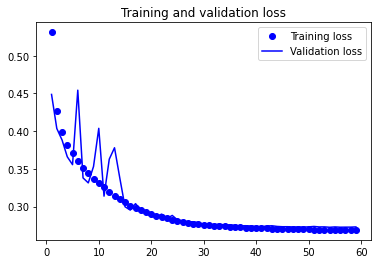

In [0]:
# plotting the results

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss, 'bo', label="Training loss")
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [22]:
# train the final model on all non-test data avaliable

x_test = []
y_test = []

for record in test_data:
  x_test.append(record[1:])
  label = int(record[0])
  y_test.append(label) 

x_test = array(x_test)
x_test = x_test.reshape((len(x_test), 1, len(x_test[0])))

test_score = model.evaluate(x_test, y_test)
print("test loss:")
print(test_score[0])
print("test accuracy:")
print(test_score[1])


2160/2160 [==============================] - 0s 84us/step
test loss:
0.283822970478623
test accuracy:
0.8685185185185185


In [0]:
model.save("/content/drive/My Drive/636project/model.h5")